# ADULT INCOME PREDICTION

## Introduction

The income gap between people has always been significant. Some people earn millions every year. Some people are not even able to survive with their salary. 

Question: Given the variables age, final weight, education level and hours worked per week, will an individual make less than or equal to 50K, or greater than 50K a year?

We will use a dataset from the 1994 Census in the US from the UCL machine learning repository, titled “Adult Data Set” (1). 

There were originally 15 variables in the dataset (c = categorical, n = numerical): 
1. Age (n)
2. Work Class (c)
3. Final Weight (n): The number of people with the same attributes
4. Education (c)
5. Education Number (n): Highest degree achieved (1 = lowest, 16 = highest)
6. Marital Status (c)
7. Occupation (c)
8. Relationship (c)
9. Race (c)
10. Sex (c)
11. Capital Gain (n) 
12. Capital Loss (n)
13. Hours per week (n)
14. Native Country (c)
15. Income (target): <=50K, >50K

## Methods

For our data analysis, we will use K- nearest neighbours to predict whether individuals will make less than or equal to 50K, or greater than 50K a year. We will use age, fnl_weight, education_num and hours_per_week as predictor variables.

As shown in the 2 graphs titled “Relationship Between Capital Gain and Income Level” and “Relationship Between Capital Loss and Income Level” below, these two variables are not very indicative of income level. There are many individuals in both income categories with 0 capital gain and loss. Therefore, for our analysis we will not be using these two variables.

We will be omitting all categorical variables in our analysis since we will not be able to analyze them with K-NN classification. 

To visualize our results, we will create scatterplots to compare the relationship between the predictor variables and target values. We will also visualize the best number of neighbours in a line graph.

## Preliminary Exploratory Data Analysis

#### Load all libraries we need:

In [1]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Reading in data from the web:

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

download.file(url, "data.csv")

names <- c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income")
census <- read_csv("data.csv", col_names = names) %>%
    mutate(income = as_factor(income))

head(census)

Parsed with column specification:
cols(
  age = col_double(),
  workclass = col_character(),
  fnlwgt = col_double(),
  education = col_character(),
  education_num = col_double(),
  marital_status = col_character(),
  occupation = col_character(),
  relationship = col_character(),
  race = col_character(),
  sex = col_character(),
  capital_gain = col_double(),
  capital_loss = col_double(),
  hours_per_week = col_double(),
  native_country = col_character(),
  income = col_character()
)



age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



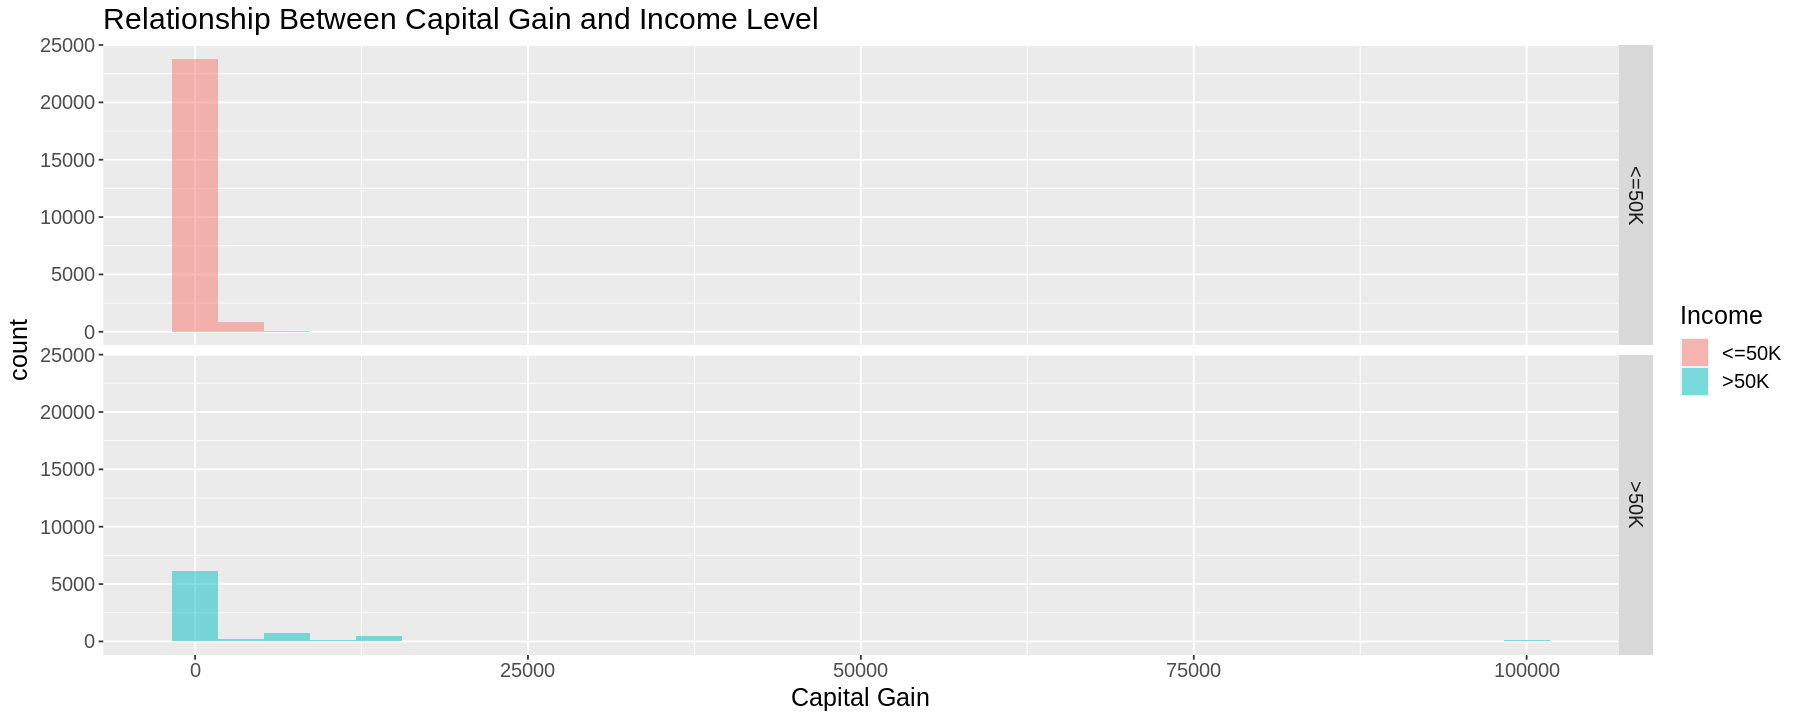

In [3]:
options(repr.plot.width = 15, repr.plot.height = 6)
gain <- census %>%
    ggplot(aes(x = capital_gain, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Capital Gain", fill = "Income") + 
    ggtitle("Relationship Between Capital Gain and Income Level") + 
    theme(text = element_text(size = 15)) 
gain

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



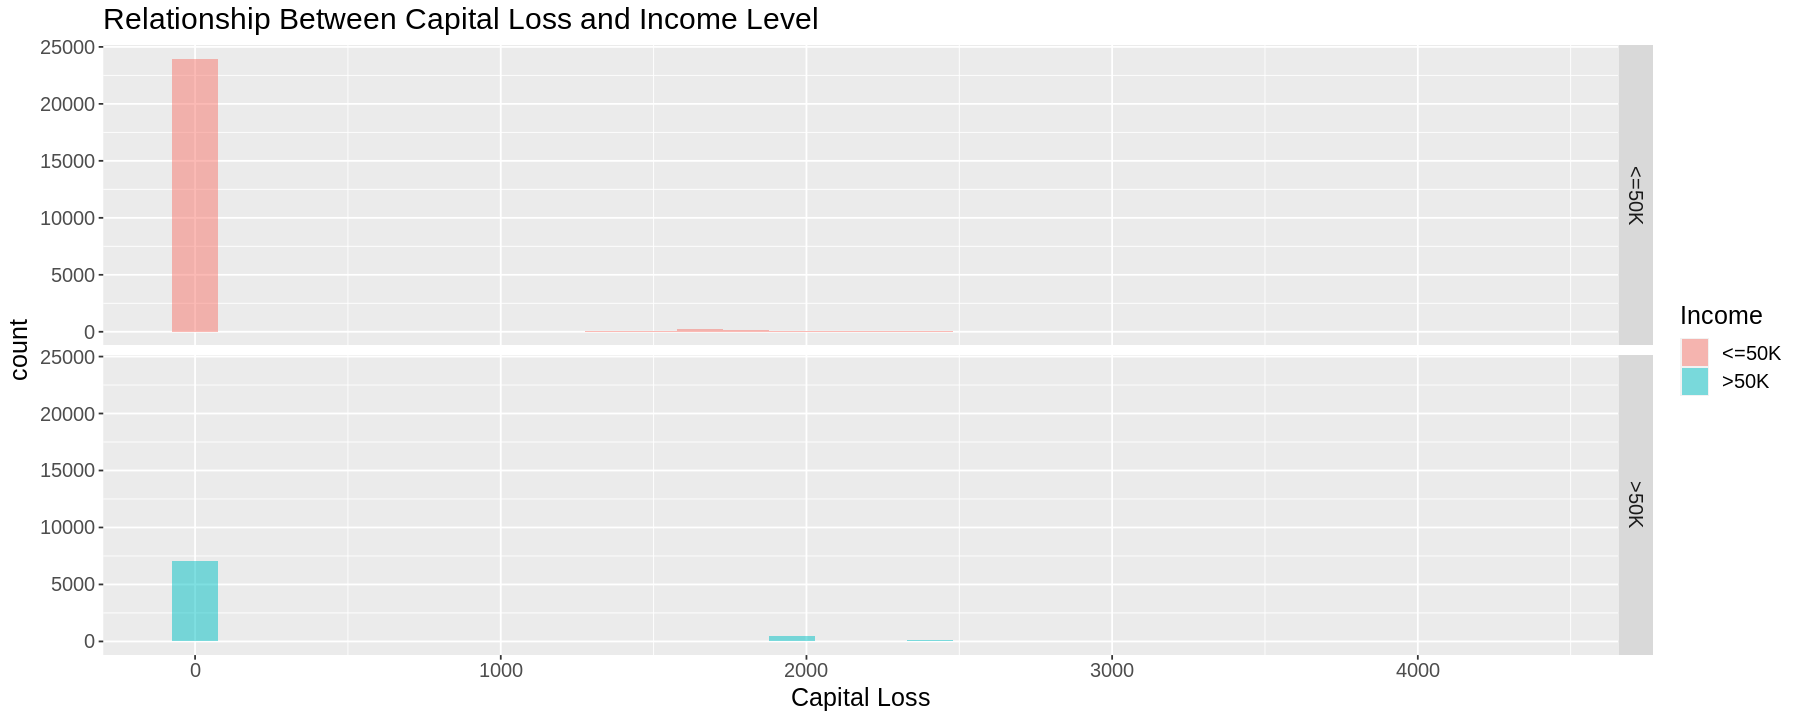

In [4]:
loss <- census %>%
    ggplot(aes(x = capital_loss, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Capital Loss", fill = "Income") + 
    ggtitle("Relationship Between Capital Loss and Income Level") + 
    theme(text = element_text(size = 15)) 
loss

#### Tidying the data:

We have selected only the predictors we will be working with.

In [5]:
census_variables <- census %>%
    select(age, fnlwgt, education_num, hours_per_week, income)
head(census_variables)

age,fnlwgt,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
39,77516,13,40,<=50K
50,83311,13,13,<=50K
38,215646,9,40,<=50K
53,234721,7,40,<=50K
28,338409,13,40,<=50K
37,284582,14,40,<=50K


#### Splitting the data into train and test sets with a 75% training split:

In [6]:
census_split <- initial_split(census_variables, prop = 0.75, strata = income)  
census_train <- training(census_split)   
census_test <- testing(census_split)

head(census_train)
# 24421 x 13
# 24421 observations in the training set with 13 categories

age,fnlwgt,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
50,83311,13,13,<=50K
38,215646,9,40,<=50K
53,234721,7,40,<=50K
28,338409,13,40,<=50K
37,284582,14,40,<=50K
49,160187,5,16,<=50K


#### Tables

Number of observations of each class. About 76% of the individuals in the training set make less than or equal to 50k a year, while 24% make greater than 50k a year.

In [7]:
num_obs <- nrow(census_train)
percentage_income <- census_train %>% 
    group_by(income) %>%
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
    )
percentage_income

`summarise()` ungrouping output (override with `.groups` argument)



income,count,percentage
<fct>,<int>,<dbl>
<=50K,18540,75.91827
>50K,5881,24.08173


The code below tells us whether any of our variables have missing values, which are shown as "?" in this data set. There are no missing values.

In [8]:
missing_count <- census_train %>%
    filter(age == "?" | education_num == "?" | hours_per_week == "?" | fnlwgt == "?" | income == "?")
missing_count

age,fnlwgt,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<dbl>,<fct>


Means of predictor variables we plan to use.

In [9]:
continuous_means <- census_train %>%
    select(age:hours_per_week) %>%
    colMeans()
continuous_means

age         fnlwgt  education_num hours_per_week 
      38.61390   189613.62647       10.08652       40.51996

#### Graphs

We used histograms to visualize the distributions of 3 of our predictor variables becuase we found that they were clear and represented our data well. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



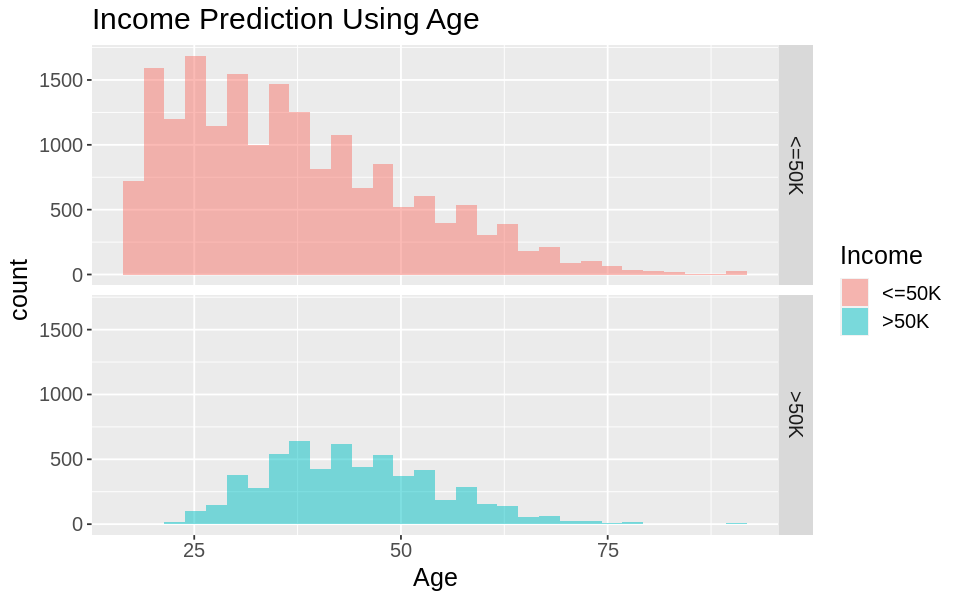

In [10]:
options(repr.plot.width = 8, repr.plot.height = 5)
age_hist <- census_train %>%
    ggplot(aes(x = age, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Age", fill = "Income") + 
    ggtitle("Income Prediction Using Age") + 
    theme(text = element_text(size = 15)) 
age_hist

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



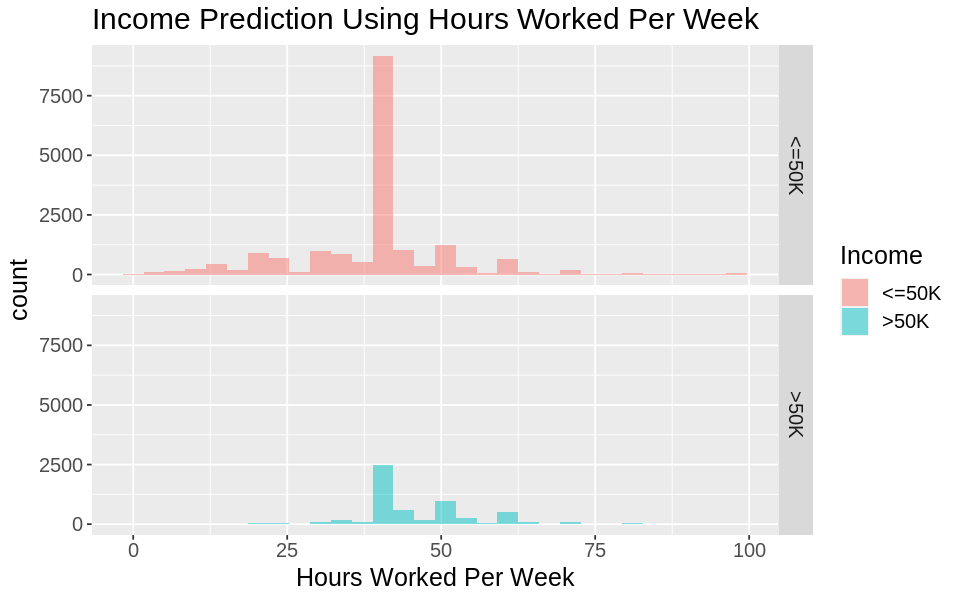

In [11]:
options(repr.plot.width = 8, repr.plot.height = 5)
hours_hist <- census_train %>%
    ggplot(aes(x = hours_per_week, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Hours Worked Per Week", fill = "Income") + 
    ggtitle("Income Prediction Using Hours Worked Per Week") + 
    theme(text = element_text(size = 15)) 
hours_hist

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



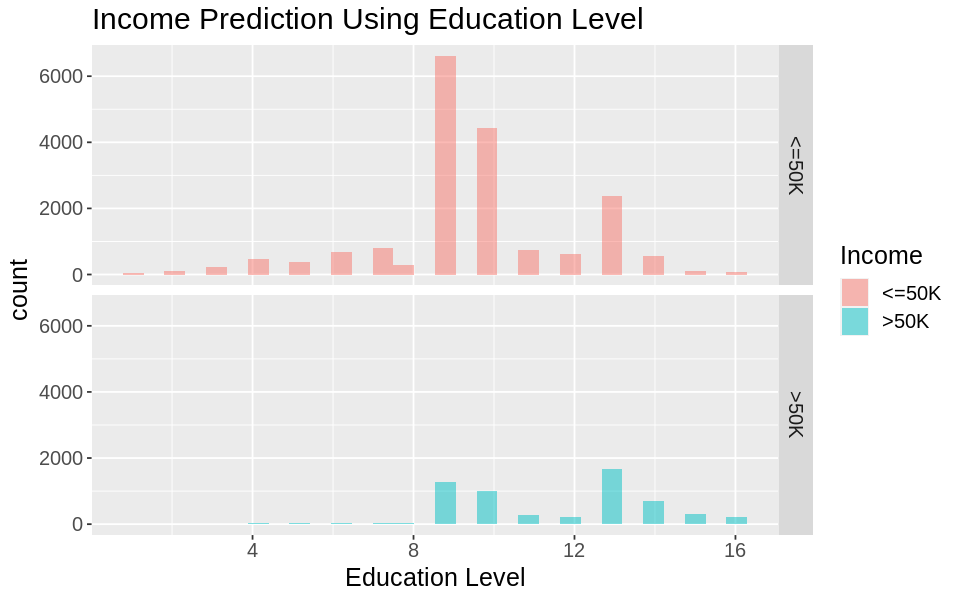

In [12]:
options(repr.plot.width = 8, repr.plot.height = 5)
education_hist <- census_train %>%
    ggplot(aes(x = education_num, fill = income)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(income)) +
    labs(x = "Education Level", fill = "Income") + 
    ggtitle("Income Prediction Using Education Level") + 
    theme(text = element_text(size = 15)) 
education_hist

## Expected Outcomes and Significance

What do you expect to find?\
According to the graphs, we expect individuals who are in their 30s with higher education to have a higher income. Hours worked per week does not seem like it will have a significant impact, since most people work 40 hours a week.

What impact could such findings have?\
With this dataset, we can see what variables affect a person’s income the most and can potentially inform people of the qualities they should improve upon to increase their income. 

What future questions could this lead to?\
Since this dataset is from 1994, how will outcomes differ compared to current data (2021)? If we have a new observation from 2021, how accurate will the prediction be if we’re using a dataset from 1994? Since we were not able to analyze categorical variables, how would these affect our predictions?

### References

1. Becker, B. and Kohavi, R. (1996). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml/datasets/Adult]. Irvine, CA: University of California, School of Information and Computer Science.